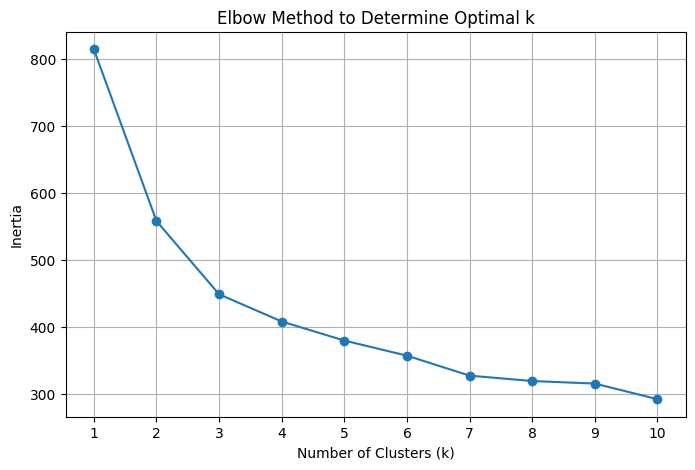

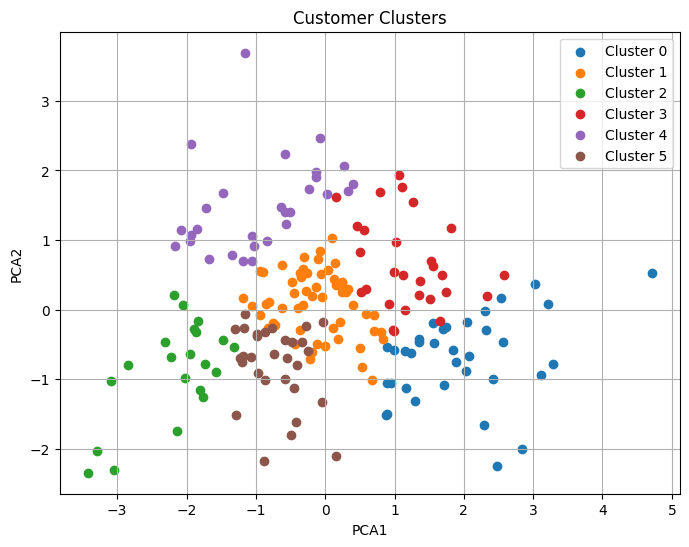

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Parse dates
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Add a 'Price' column to merged_data (derived from TotalValue and Quantity)
merged_data['Price'] = merged_data['TotalValue'] / merged_data['Quantity']

# Feature Engineering
# Aggregate transaction data for each customer
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum',    # Total quantity purchased
    'Price': 'mean',      # Average price of purchased items
    'Category': lambda x: x.mode()[0],  # Most common category
    'Region': 'first'     # Region of the customer
}).reset_index()

# One-hot encode categorical features
customer_features = pd.get_dummies(customer_features, columns=['Category', 'Region'], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['TotalValue', 'Quantity', 'Price']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Elbow Method to Determine Optimal k
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features.drop(columns=['CustomerID']))
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()

# Apply KMeans Clustering with k=6
kmeans = KMeans(n_clusters=6, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))

# Save clustering results
customer_features[['CustomerID', 'Cluster']].to_csv('FirstName_LastName_Clustering.csv', index=False)

# Visualize Clusters (optional: using first two principal components for simplicity)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
customer_pca = pca.fit_transform(customer_features.drop(columns=['CustomerID', 'Cluster']))
customer_features['PCA1'] = customer_pca[:, 0]
customer_features['PCA2'] = customer_pca[:, 1]

plt.figure(figsize=(8, 6))
for cluster in range(6):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid()
plt.show()
